# Spectrogram Channels U-net

* SPECTROGRAM-CHANNELS U-NET: A SOURCE SEPARATION MODEL VIEWING EACH CHANNEL AS THE SPECTROGRAM OF EACH SOURCE, [arXiv:1810.11520](https://arxiv.org/abs/1810.11520)
  * Jaehoon Oh∗, Duyeon Kim∗, Se-Young Yun

## Import modules

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import time
import glob

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import PIL
import imageio
from IPython import display

import tensorflow as tf
from tensorflow.keras import layers
tf.enable_eager_execution()

tf.logging.set_verbosity(tf.logging.INFO)

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
# Training Flags (hyperparameter configuration)
model_name = 'spectrogram_unet'
train_dir = 'train/' + model_name + '/exp1/'
max_epochs = 200
save_model_epochs = 20
print_steps = 50
batch_size = 1
learning_rate = 2e-4
N = 4000 # number of samples in train_dataset

BUFFER_SIZE = N
IMG_WIDTH = 256
IMG_HEIGHT = 1025

## Set up dataset with `tf.data`

In [3]:
def load_image(image_file):
  image = tf.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]
  w = w // 6

  spec = []
  for i in range(6):
    spec_img = tf.cast(image[:, i*w:(i+1)*w], tf.float32)
    # normalizing the images to [-1, 1]
    spec.append((spec_img / 127.5) - 1)
    
  mixtures = spec[0]
  targets = tf.concat(spec[1:], axis=2)
  
  return mixtures, targets

In [4]:
train_dataset = tf.data.Dataset.list_files('./datasets/spectrogram_jpg/train/*.jpg')
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(lambda x: load_image(x))
train_dataset = train_dataset.batch(batch_size)

(1, 1024, 256, 1)
(1, 1024, 256, 5)


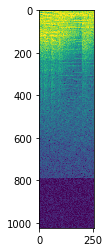

In [5]:
for mixtures, targets in train_dataset.take(1):
  print(mixtures.shape)
  print(targets.shape)
  plt.imshow(mixtures[0,:,:,0].numpy())
  plt.imshow(targets[0,:,:,3].numpy())

## Build the model

In [6]:
class ConvBlock(tf.keras.Model):
  def __init__(self, num_filters, size):
    super(ConvBlock, self).__init__()
    self.conv1 = layers.Conv2D(filters=num_filters,
                               kernel_size=(size, size),
                               padding='same',
                               use_bias=False)
    self.batchnorm1 = layers.BatchNormalization()
    self.conv2 = layers.Conv2D(filters=num_filters,
                               kernel_size=(size, size),
                               padding='same',
                               use_bias=False)
    self.batchnorm2 = layers.BatchNormalization()
  
  def call(self, x, training=True):
    x = self.conv1(x)
    x = self.batchnorm1(x, training=training)
    x = tf.nn.relu(x)
    x = self.conv2(x)
    x = self.batchnorm2(x, training=training)
    x = tf.nn.relu(x)
    
    return x

In [7]:
class EncoderBlock(tf.keras.Model):
  def __init__(self, num_filters, size):
    super(EncoderBlock, self).__init__()
    self.conv_block = ConvBlock(num_filters, 3)
    
  def call(self, x, training=True):
    encoder = self.conv_block(x, training=training)
    encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  
    return encoder_pool, encoder

In [8]:
class ConvTransposeBlock(tf.keras.Model):
  def __init__(self, num_filters, size):
    super(ConvTransposeBlock, self).__init__()
    self.convT1 = layers.Conv2DTranspose(filters=num_filters,
                                         kernel_size=(size, size),
                                         padding='same',
                                         use_bias=False)
    self.batchnorm1 = layers.BatchNormalization()
    self.convT2 = layers.Conv2DTranspose(filters=num_filters,
                                         kernel_size=(size, size),
                                         padding='same',
                                         use_bias=False)
    self.batchnorm2 = layers.BatchNormalization()
  
  def call(self, x, training=True):
    x = self.convT1(x)
    x = self.batchnorm1(x, training=training)
    x = tf.nn.relu(x)    
    x = self.convT2(x)
    x = self.batchnorm2(x, training=training)
    x = tf.nn.relu(x)
    
    return x

In [9]:
class DecoderBlock(tf.keras.Model):
  def __init__(self, num_filters, size):
    super(DecoderBlock, self).__init__()
    self.convT = layers.Conv2DTranspose(filters=num_filters,
                                        kernel_size=(size+2, size+2),
                                        strides=(2, 2),
                                        padding='same',
                                        use_bias=False)
    self.batchnorm = layers.BatchNormalization()
    self.dropout = layers.Dropout(0.4)
    self.convT_block = ConvTransposeBlock(num_filters, size)
  
  def call(self, input_tensor, concat_tensor, training=True):
    # Upsampling
    x = self.convT(input_tensor)
    x = self.batchnorm(x, training=training)
    x = tf.nn.relu(x)
    x = self.dropout(x, training=training)
    
    # concatenate
    x = tf.concat([x, concat_tensor], axis=-1)
    
    # just two consecutive conv_transpose
    x = self.convT_block(x, training=training)
    
    return x

In [19]:
class SpectrogramChannelsUNet(tf.keras.Model):
  def __init__(self):
    super(SpectrogramChannelsUNet, self).__init__()
    self.down1 = EncoderBlock(32, 3)
    self.down2 = EncoderBlock(64, 3)
    self.down3 = EncoderBlock(128, 3)
    self.down4 = EncoderBlock(256, 3)
    self.center = ConvBlock(512, 3)

    self.up1 = DecoderBlock(256, 3)
    self.up2 = DecoderBlock(128, 3)
    self.up3 = DecoderBlock(64, 3)
    self.up4 = DecoderBlock(32, 3)

    self.last = layers.Conv2D(filters=5,
                              kernel_size=(1, 1),
                              padding='same')
  
  @tf.contrib.eager.defun
  def call(self, x, training):
    # x shape == (bs, 1024, 256, 1)
    x1_pool, x1 = self.down1(x, training=training) # (bs, 512, 128, 32)
    x2_pool, x2 = self.down2(x1_pool, training=training) # (bs, 256, 64, 64)
    x3_pool, x3 = self.down3(x2_pool, training=training) # (bs, 128, 32, 128)
    x4_pool, x4 = self.down4(x3_pool, training=training) # (bs, 64, 16, 256)
    x_center = self.center(x4_pool, training=training) # (bs, 64, 16, 512)

    x5 = self.up1(x_center, x4, training=training) # (bs, 128, 32, 256)
    x6 = self.up2(x5, x3, training=training) # (bs, 256, 64, 128)
    x7 = self.up3(x6, x2, training=training) # (bs, 512, 128, 64)
    x8 = self.up4(x7, x1, training=training) # (bs, 1024, 256, 32)

    x_last = self.last(x8) # (bs, 1024, 256, 5)
    x_last = tf.math.sigmoid(x_last)

    return x_last

In [20]:
model = SpectrogramChannelsUNet()

In [21]:
for inputs, targets in train_dataset.take(1):
  #pool, original = model(inputs, training=True)
  x = model(inputs, training=True)